# Code Interpreting with GPT-4o
This example uses the E2B's [Code Interpreter](https://github.com/e2b-dev/code-interpreter) as a tool for GPT-4o. We ask GPT-4o to show a chart which means GPT will generate Python code that will get sent to E2B, we display the chart and then ask GPT-4o to reason about the generated chart and create a new chart.

In [1]:
# Get your API keys or save them to .env file.
import os
from dotenv import load_dotenv
load_dotenv()

# TODO: Get your OpenAI API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = os.getenv("E2B_API_KEY")


SYSTEM_PROMPT = """
## your job & context
you are a python data scientist. you are given tasks to complete and you run python code to solve them.
You DO NOT MAKE SYNTAX MISTAKES OR FORGET ANY IMPORTS
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment.
"""

tools = [
    {
        "type": "function",
        "function": {
          "name": "execute_python",
          "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
          "parameters": {
              "type": "object",
              "properties": {
                  "code": {
                      "type": "string",
                      "description": "The python code to execute in a single cell."
                  }
              },
              "required": ["code"]
          }
        },
    }
]

In [5]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  print(code)
  exec = e2b_code_interpreter.notebook.exec_cell(
    code,
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
    # You can also stream code execution results
    # on_result=...
  )

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

In [21]:
from openai import OpenAI
import json

client = OpenAI(api_key=OPENAI_API_KEY)

def chat(e2b_code_interpreter, user_message, base64_image = None, ):
  print(f"\n{'='*50}\nUser Message: {user_message}\n{'='*50}")

  messages = [
      {
          "role": "system",
          "content": SYSTEM_PROMPT,
      },
  ]

  if base64_image is not None:
    messages.append(
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": user_message,
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            }
          ]
        }
    )
  else:
    messages.append(
        {"role": "user", "content": user_message},
    )

  response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    tools=tools,
    tool_choice="auto"
  )
  for choice in response.choices:
    if choice.message.tool_calls and len(choice.message.tool_calls) > 0:
      for tool_call in choice.message.tool_calls:
        if tool_call.function.name == "execute_python":
          if "code" in tool_call.function.arguments:
            ######################################################## agregue esto, porque arguments era un objeto tipo str
            dictionary = json.loads(tool_call.function.arguments)
            code = dictionary["code"]  
            #########################################################
            #code = tool_call.function.arguments["code"]
          
          print("CODE TO RUN")
          print(code)
          code_interpreter_results = code_interpret(e2b_code_interpreter, code)
          return code_interpreter_results
    else:
      print("Answer:", choice.message.content)




User Message: Plot a chart visualizing the height distribution of men based on the data you know
CODE TO RUN
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the synthetic height data
mean_height = 175  # Average height in cm
std_dev_height = 7  # Standard deviation in cm
n_samples = 1000  # Number of samples

# Generate the synthetic height data
height_data = np.random.normal(mean_height, std_dev_height, n_samples)

# Plot the height distribution
plt.figure(figsize=(10, 6))
plt.hist(height_data, bins=30, color='skyblue', edgecolor='black')
plt.title('Height Distribution of Men')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
Running code interpreter...
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the synthetic height data
mean_height = 175  # Average height in cm
std_dev_height = 7  # Standard deviation in cm
n_samples = 1000  # Number of samples

# Generate the synthetic height data
height_data = np.random.norm

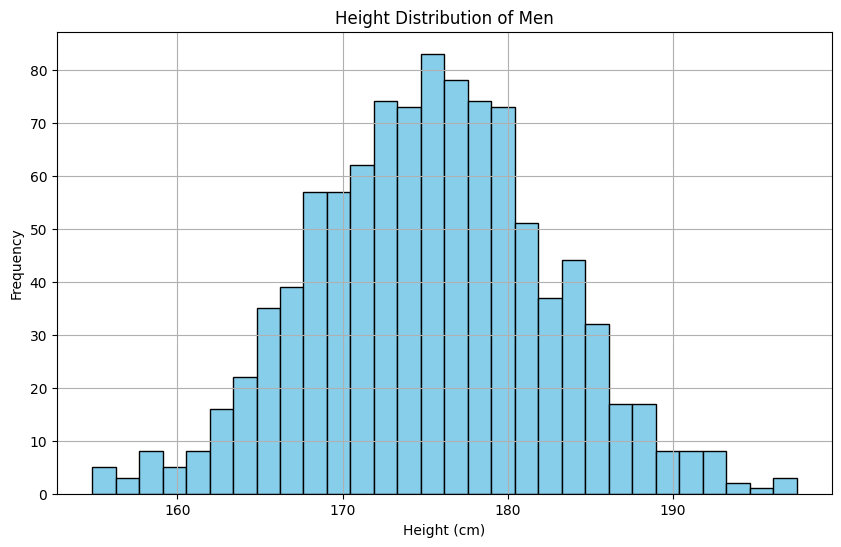

In [22]:
from e2b_code_interpreter import CodeInterpreter
code_interpreter = CodeInterpreter(api_key=E2B_API_KEY)

# 1. Ask GPT-4o to generate chart
code_interpreter_results = chat(
  code_interpreter,
  "Plot a chart visualizing the height distribution of men based on the data you know",
)
print(code_interpreter_results)
plot1 = code_interpreter_results[0]


print(plot1.raw)
plot1


User Message: Based on what you see, what's name of this distribution? Show me the distribution function
CODE TO RUN
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the normal distribution
mu = 175  # mean
sigma = 6  # standard deviation

# Generate data points for x axis
gx = np.linspace(140, 210, 1000)

# Calculate the normal distribution PDF
pdf = norm.pdf(gx, mu, sigma)

# Plot the PDF
plt.figure(figsize=(10, 6))
plt.plot(gx, pdf, label=f'Normal Distribution ($\mu={mu}$, $\sigma={sigma}$)', color='blue')
plt.title('Probability Density Function of Normal Distribution')
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
Running code interpreter...
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the normal distribution
mu = 175  # mean
sigma = 6  # standard deviation

# Generate data points for x axis
gx = np.linspace(140, 210, 1000)

# Calculate the

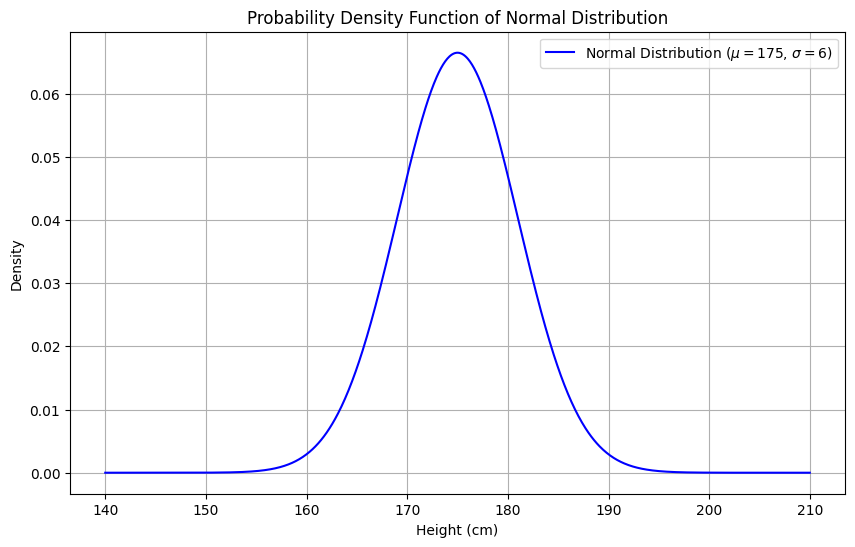

In [23]:
# 2. Feed the image back the chart to GPT-4o and ask question about the image
image = plot1.png
code_interpreter_results = chat(
  code_interpreter,
  "Based on what you see, what's name of this distribution? Show me the distribution function",
  image,
)

code_interpreter.close()

print(code_interpreter_results)
plot2 = code_interpreter_results[0]
print(plot2.raw)
plot2

# The same example, but now using file upload

In [33]:
# Get your API keys or save them to .env file.
import os
from dotenv import load_dotenv
load_dotenv()

# TODO: Get your OpenAI API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = os.getenv("E2B_API_KEY")


SYSTEM_PROMPT = """You're a python data scientist that is analyzing daily temperature of major cities. You are given tasks to complete and you run python code to solve them.

Information about the the temperature dataset:
- It's in the `/home/user/city_temperature.csv` file
- It has following columns (examples included):
  - `Region`: "North America", "Europe"
  - `Country`: "Iceland"
  - `State`: for example "Texas" but can also be null
  - `City`: "Prague"
  - `Month`: "June"
  - `Day`: 1-31
  - `Year`: 2002
  - `AvgTemperature`: temperature in celsiu, for example 24

Generally you follow these rules:
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. 
- save the visualizations to a file named 'plot.png', using the instruction: `plt.savefig('plot.png')`
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment
"""

tools = [
    {
        "type": "function",
        "function": {
          "name": "execute_python",
          "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
          "parameters": {
              "type": "object",
              "properties": {
                  "code": {
                      "type": "string",
                      "description": "The python code to execute in a single cell."
                  }
              },
              "required": ["code"]
          }
        },
    }
]

In [24]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.notebook.exec_cell(
    code,
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
    # You can also stream code execution results
    # on_result=...
  )

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

In [31]:
from openai import OpenAI
import json

client = OpenAI(api_key=OPENAI_API_KEY)

def chat(e2b_code_interpreter, user_message, base64_image = None, ):
  print(f"\n{'='*50}\nUser Message: {user_message}\n{'='*50}")

  messages = [
      {
          "role": "system",
          "content": SYSTEM_PROMPT,
      },
  ]

  if base64_image is not None:
    messages.append(
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": user_message,
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            }
          ]
        }
    )
  else:
    messages.append(
        {"role": "user", "content": user_message},
    )

  response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    tools=tools,
    tool_choice="auto"
  )
  for choice in response.choices:
    if choice.message.tool_calls and len(choice.message.tool_calls) > 0:
      for tool_call in choice.message.tool_calls:
        if tool_call.function.name == "execute_python":
          if "code" in tool_call.function.arguments:
            ######################################################## agregue esto, porque arguments era un objeto tipo str
            dictionary = json.loads(tool_call.function.arguments)
            code = dictionary["code"]  
            #########################################################
            #code = tool_call.function.arguments["code"]
          
          print("CODE TO RUN")
          print(code)
          code_interpreter_results = code_interpret(e2b_code_interpreter, code)
          return code_interpreter_results
    else:
      print("Answer:", choice.message.content)



In [26]:

def upload_dataset(code_interpreter):
  print("Uploading dataset to Code Interpreter sandbox...")
  with open("city_temperature.csv", "rb") as f:
    remote_path = code_interpreter.upload_file(f)
  print("Uploaded at", remote_path)

In [36]:
from e2b_code_interpreter import CodeInterpreter

with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:

  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  # 1. Ask GPT-4o to generate chart
  code_interpreter_results = chat(
    code_interpreter,
    "Plot average temperature over the years in Algeria"
  )
  if code_interpreter_results:
    first_result = code_interpreter_results[0]


    file_in_bytes = code_interpreter.download_file("/home/user/plot.png")  
    # Save file to local filesystem
    with open("plot.png", "wb") as f:  
        f.write(file_in_bytes) 
  else:
    raise Exception("No code results")


  # This will render the image
  # You can also access the data directly
  # first_result.png
  # first_result.jpg
  # first_result.pdf
  # ...
  first_result


Uploading dataset to Code Interpreter sandbox...
Uploaded at /home/user/city_temperature.csv

User Message: Plot average temperature over the years in Algeria
CODE TO RUN
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/home/user/city_temperature.csv')

# Filter data for Algeria
algeria_data = df[df['Country'] == 'Algeria']

# Calculate the average temperature for each year
avg_temp_per_year = algeria_data.groupby('Year')['AvgTemperature'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(avg_temp_per_year['Year'], avg_temp_per_year['AvgTemperature'], marker='o')
plt.title('Average Temperature in Algeria Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.savefig('plot.png')
plt.show()
Running code interpreter...


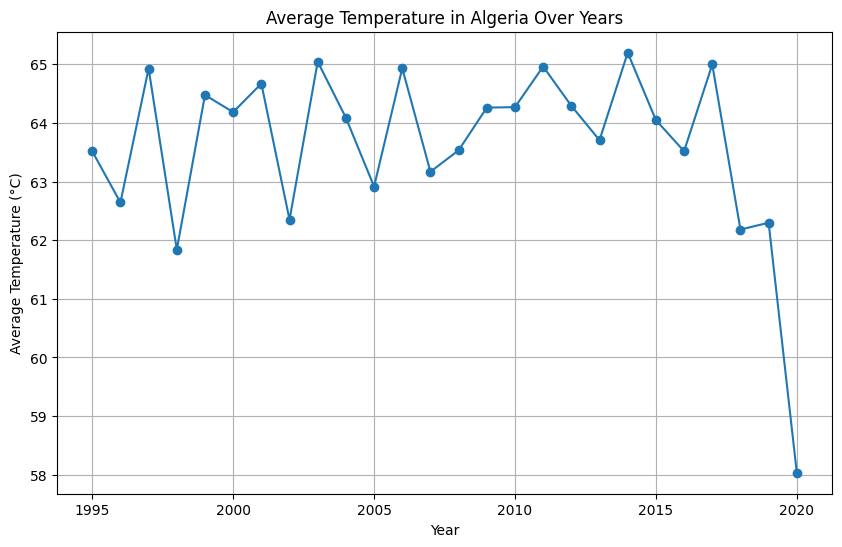

In [35]:
first_result